# 0.필요한 라이브러리 import

In [1]:
from importlib.metadata import version
import tensorflow
import summa

import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 1.데이터 수집하기

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

data.sample(10)

,headlines,text
55183,US foolishly spent $7 trillion in Middle East:...,US President Donald Trump has said that the US...
41936,No proposal to scrap article giving J&K specia...,The Home Ministry on Tuesday informed the Lok ...
63972,NIA charges Islamic preacher Zakir Naik of inc...,The National Investigation Agency (NIA) on Thu...
87321,India records its first three cases of Zika vi...,The WHO on Friday confirmed India's first thre...
56067,Google Chrome beta allows users to mute autopl...,Google has announced a new Chrome update calle...
40143,Complaint against UP Dy CM for calling Sita te...,"A lawyer from Sitamarhi, Bihar, has filed a co..."
47529,Priyanka denies suing Nirav Modi over not payi...,Actress Priyanka Chopra's spokesperson has den...
43765,"Airline mixes up between 2 dogs, flies both to...",United Airlines has launched an investigation ...
97828,I have to see non-talented actors due to favou...,Actor Rajkummar Rao has said that due to favou...
44164,At least 49 killed in Nepal plane crash,At least 49 people have been killed after a US...


# 2.데이터 전처리하기 (추상적 요약)

중복된 데이터 제거

In [3]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [4]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


결측치 확인

In [5]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

텍스트 정규화와 불용어 제거

In [6]:
# 텍스트 정규화를 위한 사전(dictionary) 정의
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [7]:
#NLTK에서 제공하는 불용어 리스트를 참조해 불용어 리스트 생성
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [8]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [9]:
# 전체 text 데이터에 대한 전처리
clean_text = []

for x in data["text"]:
    clean_text.append(preprocess_sentence(x))

# 전체 Summary 데이터에 대한 전처리
clean_headlines = []

for x in data["headlines"]:
    clean_headlines.append(preprocess_sentence(x,False))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])
print("headlines 전처리 후 결과: ", clean_headlines[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [10]:
#다시 데이터프레임화
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [11]:
# 결측치 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


샘플의 최대 길이 정하기

In [12]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


In [13]:
text_max_len = 40
headlines_max_len = 10

In [14]:
# max_len 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 
# 포함할 수 있는지 통계로 확인하는 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [15]:
# 통계 확인
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


In [16]:
# 정의한 text_max_len과 summary_max_len의 길이보다 큰 샘플을 제외
data = data[data["text"].apply(lambda x: len(x.split()) <= text_max_len) &
              data["headlines"].apply(lambda x: len(x.split()) <= headlines_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 74102


시작 토큰과 종료 토큰 추가하기

In [17]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [18]:
# Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

훈련 데이터와 테스트 데이터를 분리

In [19]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[15719 27117 36429 ... 30571 68986 38010]


In [20]:
# 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의 -> 잘 섞인 샘플
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [21]:
# 8:2의 비율로 훈련 데이터, 테스트 데이터 분리
n_of_val = int(len(encoder_input)*0.2)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


단어 집합(vocabulary) 및 정수 인코딩

In [22]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [23]:
# 등장 빈도수가 9회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 9
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 61432
등장 빈도가 8번 이하인 희귀 단어의 수: 44561
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 16871
단어 집합에서 희귀 단어의 비율: 72.53711420757911
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.06130044978711


In [24]:
# 단어 집합의 크기 제한
src_vocab = 16800
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 16,800으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [25]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[32, 46, 3, 124, 2850, 1898, 224, 2731, 9488, 485, 1294, 3, 11303, 195, 299, 83, 277, 81, 2336, 1971, 1972, 791, 2183, 149, 500, 4], [133, 9, 87, 661, 69, 1161, 4608, 480, 77, 171, 1450, 3139, 107, 15069, 590, 5523, 590, 886, 7641, 92, 926, 181, 3316, 1985, 15069, 590, 4608, 201, 383, 633, 2], [6626, 5388, 13719, 5, 35, 488, 593, 6531, 681, 960, 569, 4166, 1692, 1183, 1882, 5823, 3592, 5324, 9250, 6531, 4207, 3068, 5, 9017, 1453, 2900, 1790, 275, 98, 2507, 10301]]


In [26]:
# headlines 데이터에도 적용

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27232
등장 빈도가 5번 이하인 희귀 단어의 수: 18184
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9048
단어 집합에서 희귀 단어의 비율: 66.7743830787309
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.962057295063397


In [27]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 171, 530, 176, 84, 39, 6946, 1030, 7, 2533, 8219], [1, 52, 7, 43, 953, 3125, 4, 224], [1, 6482, 16, 2730, 3, 777, 106, 8220], [1, 828, 2287, 253, 172, 5, 967, 169, 4, 70], [1, 5418, 2534, 1783, 30, 48, 9]]
target
decoder  [[171, 530, 176, 84, 39, 6946, 1030, 7, 2533, 8219, 2], [52, 7, 43, 953, 3125, 4, 224, 2], [6482, 16, 2730, 3, 777, 106, 8220, 2], [828, 2287, 253, 172, 5, 967, 169, 4, 70, 2], [5418, 2534, 1783, 30, 48, 9, 2]]


---
요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않아요. 그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 거예요. 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을 테니까요.

In [28]:
# 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 
# 각각 drop_train과 drop_test에 라는 변수에 저장후 모두 삭제
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


패딩 적용

In [29]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='pre')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='pre')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='pre')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='pre')

# 3.어텐션 메커니즘 사용하기 (추상적 요약)

RNN을 이용한 인코더, 디코더 정의

In [30]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
x = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
x = encoder_lstm2(x)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(x)

In [31]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [32]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2150400     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

어텐션 메커니즘 추가

In [33]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2150400     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

# 4. 실제 결과와 요약문 비교하기 (추상적 요약)

모델 훈련 및 시각화

In [34]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
232/232 [==============================] - 26s 80ms/step - loss: 6.2526 - val_loss: 5.8649
Epoch 2/50
232/232 [==============================] - 18s 77ms/step - loss: 5.8966 - val_loss: 5.7506
Epoch 3/50
232/232 [==============================] - 18s 78ms/step - loss: 5.7622 - val_loss: 5.5614
Epoch 4/50
232/232 [==============================] - 18s 79ms/step - loss: 5.5180 - val_loss: 5.3556
Epoch 5/50
232/232 [==============================] - 19s 80ms/step - loss: 5.2448 - val_loss: 5.1179
Epoch 6/50
232/232 [==============================] - 19s 81ms/step - loss: 4.9873 - val_loss: 4.8978
Epoch 7/50
232/232 [==============================] - 19s 83ms/step - loss: 4.7585 - val_loss: 4.7425
Epoch 8/50
232/232 [==============================] - 19s 84ms/step - loss: 4.5557 - val_loss: 4.6092
Epoch 9/50
232/232 [==============================] - 20s 85ms/step - loss: 4.3900 - val_loss: 4.5274
Epoch 10/50
232/232 [==============================] - 20s 85ms/step - loss: 4.242

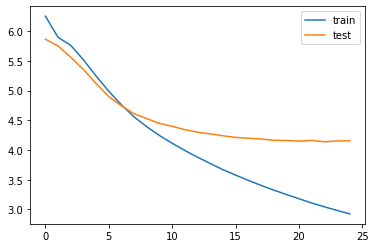

In [35]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

인퍼런스 모델 구현

In [36]:
# 원문 단어 집합에서 정수 -> 단어를 얻음
src_index_to_word = src_tokenizer.index_word
# 요약 단어 집합에서 단어 -> 정수를 얻음
tar_word_to_index = tar_tokenizer.word_index
# 요약 단어 집합에서 정수 -> 단어를 얻음
tar_index_to_word = tar_tokenizer.index_word 

In [37]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [38]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [39]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

모델 테스트

In [40]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp = ''
    for i in input_seq:
        # 0은 패딩된 값이므로 제외
        if (i != 0 and i != tar_index_to_word.get('sostoken', -1) and i != tar_index_to_word.get('eostoken', -1)):
            temp = temp + tar_index_to_word[i] + ' '
    return temp.strip()

In [41]:
for i in range(0, 50):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : minor leakage detected acid storage plant sterlite copper tamil nadu tuticorin sealed protests last month look decided evacuate storage tomorrow safety district collector sandeep said added necessary security protocols followed 
실제 요약 : sostoken acid leak detected at sealed sterlite plant in tn
예측 요약 :  tn govt bans sale of sterlite plant from sterlite


원문 : release date manoj bajpayee starrer announced september manoj best actor award film indian film festival melbourne jain directorial debut film also special jury mention festival film also stars neeraj 
실제 요약 : sostoken release date of manoj bajpayee announced
예측 요약 :  release date of akshay kumar starrer starrer hits out


원문 : ernakulam principal sessions court kerala thursday sentenced convict islam death raping murdering law student april raped murdered residence allegedly influence alcohol murder led widespread public protests debates women safety state 
실제 요약 : sostoken rape and murder convict sentenced to death
예측 요약 : 

예측 요약 :  sania mirza to marry girlfriend at their wedding reports


원문 : stating india million internet subscribers telecom regulatory authority india chairman rs sharma said internet kept free open recommendations net neutrality trai tuesday said telecom operators barred discriminatory providing internet access 
실제 요약 : sostoken internet should not be trai chairman
예측 요약 :  india internet internet access to be data by india


원문 : national award winning actress usha jadhav revealing faced casting couch said asked give something return star film said something lines money told money sleeping producer director added 
실제 요약 : was told to sleep with director says national award winner
예측 요약 :  have not part of casting couch in wood director


원문 : nine year old girl allegedly gangraped killed along minor brother sunday bihar bodies found bank river search launched return home evening police said parents identified three persons village culprits 
실제 요약 : yr old girl gangraped killed with m

예측 요약 :  google unveils st ever art of its hawking ever


원문 : uttar pradesh labour minister swami prasad maurya friday claimed congress president rahul gandhi deserve lead india oldest political party maurya said rahul gandhi continuously calling prime minister thief look decency modi responding 
실제 요약 : sostoken rahul is unfit to be cong chief up minister
예측 요약 :  rahul gandhi is not just pappu rahul gandhi pappu


원문 : bjp president amit shah monday claimed congress leaders ashamed saying bharat mata ki jai addressing rally poll bound madhya pradesh also asked opposition party give details performance power lauded state government bringing huge reforms agriculture sector 
실제 요약 : sostoken cong leaders ashamed of saying bharat ki jai shah
예측 요약 :  amit shah shah calls for shah on his rally


원문 : indian origin ravindra become first non white circuit judge old bailey central criminal court england wales currently also youngest judge court called bar interview year old said often mista

예측 요약 :  player fined for ball tampering game of play ball


원문 : former environment minister jairam ramesh sunday rejected reports claiming role granting clearance sterlite copper plant tuticorin said became environment minister may sterlite project received three rounds march january claimed facts deliberately distorted question role 
실제 요약 : no role in giving clearance to sterlite plan ex minister
예측 요약 :  sc issues order on sterlite plant sale of sterlite


원문 : bjp pulled alliance pdp repeated attacks forces civilians valley announcing split bjp general secretary ram madhav said centre tried end end pained say state government also part failed control valley situation 
실제 요약 : bjp pulls out of alliance with pdp in jammu kashmir
예측 요약 :  will not allow any alliance with militants militants abdullah


원문 : uber ceo dara khosrowshahi said relationship founder former chief travis kalanick fine strained khosrowshahi said reason lot happened past right adding nobody wants blame individu

예측 요약 :  pak court issues disqualification of india to pak polls


원문 : union finance minister arun jaitley friday accused congress kashmir stated mistakes hurting kashmir said problem kashmir begin arrival bjp government role kashmir old chapters added everyone knows governments formed valley congress rule 
실제 요약 : sostoken congress past mistakes kashmir not bjp jaitley
예측 요약 :  pm modi should be allowed to pm modi candidate


원문 : actress sridevi denied reports younger daughter khushi kapoor television dance reality show day laughing rumour added sridevi reported khushi auditioned remo souza dance show reveal identity reportedly recognised performed remo 
실제 요약 : sostoken sridevi denies report of daughter in dance show
예측 요약 :  my wife was my mother janhvi on sridevi demise


원문 : ayushmann khurrana tabu radhika apte starrer released today tale turns wrote quint film absolute treat thriller experts said ndtv indian express wrote rated 
실제 요약 : sostoken ayushmann tabu radhika starrer 

# 5.Summa을 이용해서 추출적 요약해보기

In [46]:
from summa.summarizer import summarize

if not isinstance(clean_text, str):
    clean_text = str(clean_text)

print(clean_text[:600])
print(len(clean_text))

y=summarize(clean_text, ratio=0.8)

print('Summary:')
print(y[:600])
print(len(y))

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets 
25272452
Summary:

0


 ## Extractive 요약 Vs  Extractive 요약

# 회고

LSTM을 이용해 인코더, 디코더도 생성 해보고 거기에 어텐션 메커니즘도 적용해 보면서 저번주에 배웠던 LSTM,어텐션 매케니즘에 대해서 복습 하면서 더 깊게 이해한것 같아 뜻 깊은 시간이 되었다.

추출적 요약을 대략 1시간정도 요소 된거 같다ㅠ

노드에선 쉽다고 했는데 난 요약본이 나오지 않아 오랜시간 애먹었다ㅠ